In [1]:
import os
import pandas as pd
import supereeg as se
import numpy as np
import copy
import nibabel as nib
from nilearn import plotting as ni_plt
from nilearn.image import resample_img
from nilearn import datasets, image
from scipy.spatial.distance import pdist, cdist
import scipy 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.colors as mplcol
import matplotlib as mpl
import seaborn as sns
from scipy.io import loadmat

/Users/lucyowen/.pyenv/versions/3.7.2/envs/my-data-project/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:

def _near_neighbor(bo, full_bo): #TODO: should this be part of bo.get_locs() or Brain.__init__, or possibly model.__init__?
    """
    Finds the nearest voxel for each subject's electrode location and uses
    that as revised electrodes location matrix in the prediction.

    Parameters
    ----------

    bo : Brain object
        Brain object to update

    full_bo : Brain object
        Brain object for the nearests locations used to predict


    Returns
    ----------
    bo : Brain object
        A new updated brain object

    """

    nbo = copy.deepcopy(bo) #FIXME: copying is expensive...
    nbo.orig_locs = nbo.locs
    d = cdist(nbo.locs, full_bo.locs, metric='Euclidean')
    for i in range(len(nbo.locs)):
        min_ind = list(zip(*np.where(d == d[i].min())))[0]
        nbo.data.iloc[:, min_ind[0]] = full_bo.data.iloc[:, min_ind[1]]
    return nbo


In [4]:
n_nets = 7

In [5]:
pwd

'/Users/lucyowen/repos/pca_paper-1/code/notebooks'

In [6]:
fig_dir = '../../paper/figs/source/networks'
network_dir = '../../data/yeo_networks'

In [7]:
nii_bo_dir = '../../data/niis'
if not os.path.exists(nii_bo_dir):
    os.makedirs(nii_bo_dir)
pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
if not os.path.exists(pca_nii_bo_dir):
    os.makedirs(pca_nii_bo_dir)
networks_nii_bo_dir = os.path.join(nii_bo_dir, 'networks')
if not os.path.exists(networks_nii_bo_dir):
    os.makedirs(networks_nii_bo_dir)
    

In [8]:
template = se.helpers._std(res=4)

In [9]:
ddir = '../../data/'

In [10]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [11]:
yeo_colors = pd.read_fwf(os.path.join(network_dir, 'Yeo2011_' + str(n_nets) + 'Networks_ColorLUT.txt'))
yeo_colors.columns = ["inds", "networks", "x", "y", "z", "labels"]


In [12]:
if n_nets == 17:
    yeo_color_labels = ['visual peripheral', 'visual central', 'somatomotor A', 'somatomotor B', 'dorsal attention A', 
                        'dorsal attention B', 'ventral attention', 'salience', 'limbic A', 'limbic B', 'control C', 
                        'control A', 'control B', 'default D (auditory)', 'default C', 'default A', 'default B']
elif n_nets == 7:
    yeo_color_labels = ['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Limbic ',
                        'Frontoparietal', 'Default']
    
yeo_colors['labels'] = yeo_color_labels

In [13]:
yeo_colors

inds     networks    x    y    z             labels
0     1  7Networks_1  120   18  134             Visual
1     2  7Networks_2   70  130  180        Somatomotor
2     3  7Networks_3    0  118   14   Dorsal Attention
3     4  7Networks_4  196   58  250  Ventral Attention
4     5  7Networks_5  220  248  164            Limbic 
5     6  7Networks_6  230  148   34     Frontoparietal
6     7  7Networks_7  205   62   78            Default

In [14]:
yeo_file = os.path.join(network_dir, 'Yeo2011_'+ str(n_nets) + 'Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz')
yeo = se.load(yeo_file)

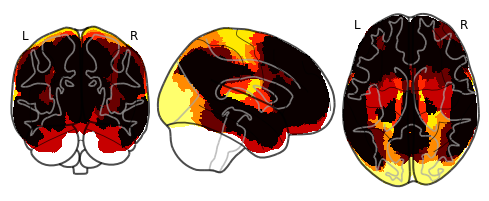

In [15]:
yeo.plot_glass_brain()

In [16]:
downsampled = 4
downsampled_nii = se.Nifti(resample_img(yeo, target_affine=np.eye(3)*downsampled, interpolation='nearest'))

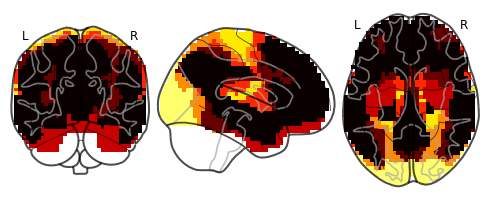

In [17]:
downsampled_nii.plot_glass_brain()

In [69]:
template = se.helpers._std(res=4)

In [70]:
template.get_locs()

x     y     z
0      73.0 -33.0  -3.0
1      73.0 -33.0   1.0
2      73.0 -29.0  -7.0
3      73.0 -29.0  -3.0
4      69.0 -49.0 -11.0
...     ...   ...   ...
30660 -71.0 -25.0  -7.0
30661 -71.0 -25.0   5.0
30662 -71.0 -25.0   9.0
30663 -71.0 -21.0 -15.0
30664 -71.0 -21.0 -11.0

[30665 rows x 3 columns]

In [19]:
yeo_bo = se.Brain(downsampled_nii)

In [68]:
yeo_bo.get_locs()

x     y     z
0     -68.0 -49.0   0.0
1     -68.0 -49.0   4.0
2     -68.0 -45.0  -8.0
3     -68.0 -45.0  -4.0
4     -68.0 -45.0   0.0
...     ...   ...   ...
16452  68.0  -9.0  28.0
16453  68.0  -5.0  12.0
16454  68.0  -5.0  16.0
16455  68.0  -5.0  20.0
16456  68.0  -5.0  24.0

[16457 rows x 3 columns]

In [21]:
yeo_bo.save(os.path.join(networks_nii_bo_dir, 'yeo_bo.bo'))

In [22]:
# magma_colors = np.array([[0.368733  , 0.002724  , 0.650601  ],
#        [0.50022302, 0.01389304, 0.65714894],
#        [0.6201179 , 0.09824851, 0.61470924],
#        [0.86846771, 0.37314094, 0.39753518],
#        [0.93002341, 0.47633225, 0.32375425],
#        [0.97434661, 0.58904578, 0.24948002],
#        [0.99401233, 0.70882914, 0.18102124]])
# magma_colors.shape

In [23]:
### Just for 17! 
# magma_colors = color_stacked/255

In [24]:
# data_vals = yeo_bo.get_data().values.tolist()
# color_all = np.array([])
# for i, v in enumerate(data_vals[0]):
#     ind_color = int(v-1)
#     if color_all.shape[0]==0:
#         color_all = magma_colors[ind_color]
#     else:
#         color_all = np.vstack((color_all, magma_colors[ind_color]))


In [25]:

color_stacked = np.array([])
for i in np.arange(0,n_nets+1):
    if color_stacked.shape[0]==0:
        color_stacked = yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values
    else:
        color_stacked = np.vstack((color_stacked, yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values))
color_stacked = color_stacked/255

In [26]:
color_stacked

array([[0.47058824, 0.07058824, 0.5254902 ],
       [0.2745098 , 0.50980392, 0.70588235],
       [0.        , 0.4627451 , 0.05490196],
       [0.76862745, 0.22745098, 0.98039216],
       [0.8627451 , 0.97254902, 0.64313725],
       [0.90196078, 0.58039216, 0.13333333],
       [0.80392157, 0.24313725, 0.30588235]])

In [27]:

data_vals = yeo_bo.get_data().values.tolist()
color_all = np.array([])
for i, v in enumerate(data_vals[0]):
    ind_color = int(v-1)
    if color_all.shape[0]==0:
        color_all = color_stacked[ind_color]
    else:
        color_all = np.vstack((color_all, color_stacked[ind_color]))
        

In [28]:
color_all

array([[0.80392157, 0.24313725, 0.30588235],
       [0.80392157, 0.24313725, 0.30588235],
       [0.80392157, 0.24313725, 0.30588235],
       ...,
       [0.2745098 , 0.50980392, 0.70588235],
       [0.2745098 , 0.50980392, 0.70588235],
       [0.2745098 , 0.50980392, 0.70588235]])

In [194]:
yeo_bo.get_locs().values

array([[-68., -49.,   0.],
       [-68., -49.,   4.],
       [-68., -45.,  -8.],
       ...,
       [ 68.,  -5.,  16.],
       [ 68.,  -5.,  20.],
       [ 68.,  -5.,  24.]])

In [195]:
color_all.shape

(16457, 3)

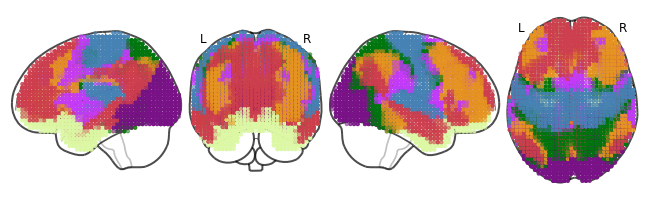

In [32]:
yeo_all_locs = yeo_bo.get_locs().values
ni_plt.plot_connectome(np.eye(yeo_all_locs.shape[0]), yeo_all_locs, output_file=None,
                               node_kwargs={'alpha': 0.5, 'edgecolors': None},
                               node_size=10, node_color=color_all, display_mode='lyrz')



In [33]:
yeo_all_locs.shape

(16457, 3)

In [34]:
color_all.shape

(16457, 3)

In [35]:
# downsampled = 6
# downsampled_nii = se.Nifti(resample_img(yeo, target_affine=np.eye(3)*downsampled, interpolation='nearest'))

In [36]:
# yeo_bo = se.Brain(downsampled_nii)
# yeo_bo.save(os.path.join(networks_nii_bo_dir, 'yeo_bo_6mm.bo'))

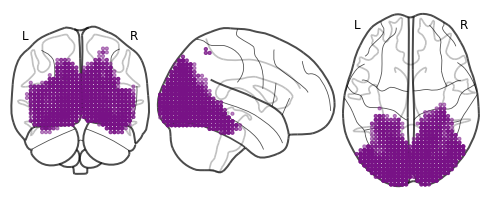

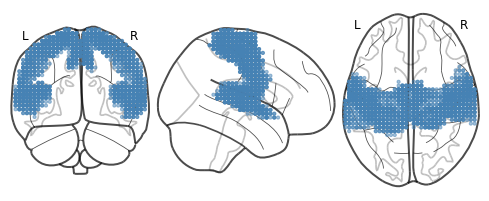

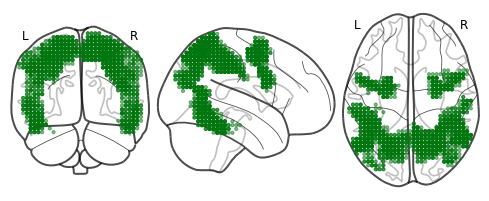

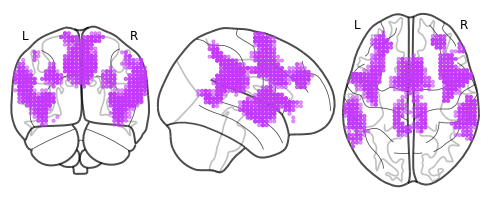

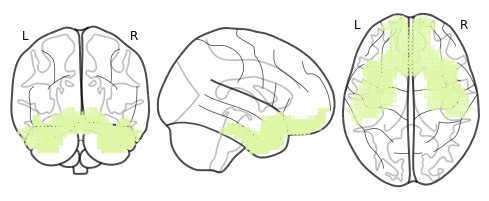

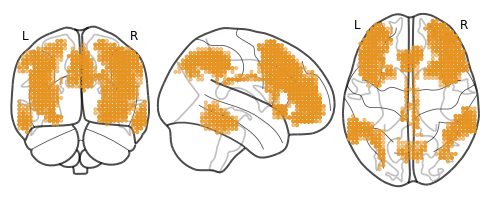

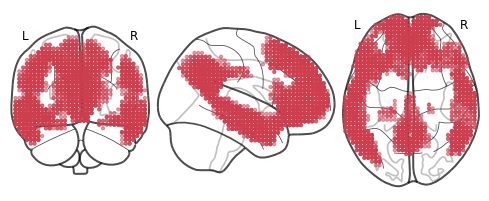

In [196]:
for n in np.arange(1, n_nets+1):
    mask_n = yeo_bo.get_data()==n
    masked_locs = yeo_bo.get_locs().values[mask_n.values.ravel()]
    bo_n = se.Brain(data=np.atleast_2d(np.ones(masked_locs.shape[0])), locs=masked_locs)
    locs = bo_n.get_locs().values
    #colors = magma_colors[n-1]
    #colors = color_stacked[n-1]
    colors = color_all[mask_n.values.ravel()]
    ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': 0.5, 'edgecolors': None},
                                   node_size=10, node_color=colors)
    outfile = os.path.join(networks_nii_bo_dir, 'bo_network_' + str(n))
    bo_n.save(outfile)

In [38]:
networks_nii_bo_dir

'../../data/niis/networks'

In [124]:
yeo_nii = se.load(os.path.join(networks_nii_bo_dir, 'yeo_bo.bo'), return_type='nii', vox_size=4)




In [40]:
yeo_bo = se.load(os.path.join(networks_nii_bo_dir, 'yeo_bo.bo'))

In [41]:
yeo_bo.get_data()

0      1      2      3      4      5      6      7      8      9      ...  \
0    7.0    7.0    7.0    7.0    7.0    7.0    7.0    2.0    4.0    7.0  ...   

   16447  16448  16449  16450  16451  16452  16453  16454  16455  16456  
0    2.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0  

[1 rows x 16457 columns]

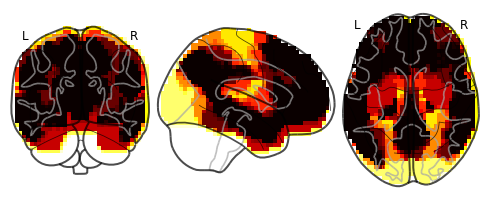

In [126]:
yeo_nii.plot_glass_brain()

In [127]:
yeo_nii.get_locs()

x     y     z
0     -68.0 -48.0  -2.0
1     -68.0 -48.0   2.0
2     -68.0 -48.0   6.0
3     -68.0 -44.0 -10.0
4     -68.0 -44.0  -6.0
...     ...   ...   ...
21856  72.0  -4.0  10.0
21857  72.0  -4.0  14.0
21858  72.0  -4.0  18.0
21859  72.0  -4.0  22.0
21860  72.0  -4.0  26.0

[21861 rows x 3 columns]

In [62]:
sub_nii = se.load('std', vox_size=4)
sub_locs = sub_nii.get_locs().values
#sub_nii.save(os.path.join(fig_dir, '4mm_brain.nii'))

In [66]:
sub_locs.shape

(30665, 3)

In [56]:
# conditions = ['intact']

# for e, c in enumerate(conditions):
    
#     for pc in np.arange(1) + 1:
        

#         b_file = os.path.join(pca_nii_bo_dir,f'{c}_{pc}_pca.bo')
#         pc_bo = se.load(b_file)
#         nii_bo_best = se.helpers._brain_to_nifti(pc_bo, sub_nii)
#         #pc_nii = se.load(b_file, return_type='nii', vox_size=4)
#         nii_bo_best.plot_glass_brain()
#         mask = nii_bo_best.get_data() > 0
#         rounded_vals = np.round_(yeo_nii.get_data()[mask])
#         counts = np.array(np.unique(rounded_vals[~np.isnan(rounded_vals)], return_counts=True))
#         #counts = np.array(np.unique(yeo_nii.get_data()[mask], return_counts=True))
        
#         copied = yeo_nii.get_data().copy()

In [57]:
# conditions = ['intact', 'paragraph', 'rest', 'word']
# #conditions = ['word']

# for e, c in enumerate(conditions):
    
#     for pc in np.arange(4) + 1:
        

#         b_file = os.path.join(pca_nii_bo_dir,f'{c}_{pc}_pca.bo')
#         pc_bo = se.load(b_file)
#         nii_bo_best = se.helpers._brain_to_nifti(pc_bo, sub_nii)
#         #pc_nii = se.load(b_file, return_type='nii', vox_size=4)
#         nii_bo_best.plot_glass_brain()
#         mask = nii_bo_best.get_data() > 0
#         rounded_vals = np.round_(yeo_nii.get_data()[mask])
#         counts = np.array(np.unique(rounded_vals[~np.isnan(rounded_vals)], return_counts=True))
#         #counts = np.array(np.unique(yeo_nii.get_data()[mask], return_counts=True))
        
#         copied = yeo_nii.get_data().copy()
#         copied[mask + 0 == 0] = 0.
#         #mask = mask *1
        
#         #copied[mask] = 0
#         temp_mask = se.Nifti(copied, nii_bo_best.get_affine())
#         temp_mask.plot_glass_brain()
#         temp_bo = se.Brain(temp_mask)
#         temp_bo.plot_locs()
#         outfile = os.path.join(networks_nii_bo_dir, f'{c}_{pc}_network.bo')
#         temp_bo.save(outfile)

#         data_vals = temp_bo.get_data().values.tolist()
#         color_all = np.array([])
#         for i, v in enumerate(data_vals[0]):
#             ind_color = int(v-1)
#             if color_all.shape[0]==0:
#                 color_all = color_stacked[ind_color]
#             else:
#                 color_all = np.vstack((color_all, color_stacked[ind_color]))


#         locs = temp_bo.get_locs().as_matrix()
#         ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
#                                        node_kwargs={'alpha': 0.5, 'edgecolors': None},
#                                        node_size=10, node_color=color_all)


#         ni_plt.show()

#         nets = counts[0][counts[0]>0]
#         counts = counts[1][counts[0]>0]

#         pie_colors = np.array([])
#         color_labels = []

#         for net in nets:
#             n = int(round(net))
#             if pie_colors.shape[0]==0:
#                 pie_colors = color_stacked[int(n-1)]
#                 color_labels.append(yeo_colors[yeo_colors.inds==n]['labels'].values[0])
#             else:
#                 pie_colors = np.vstack((pie_colors, color_stacked[int(n-1)]))
#                 color_labels.append(yeo_colors[yeo_colors.inds==n]['labels'].values[0])

#         print(color_labels)

#         #scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['Normed_corr'])[0]
#         #scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['new_normed_corr'])[0]
#         scale_pie = 1
#         print(scale_pie)
#         size = 1

#         fig = plt.figure(figsize=[10*scale_pie, 10*scale_pie])
#         patches, texts = plt.pie(counts/counts.sum(), colors=sns.color_palette(pie_colors), radius=scale_pie, shadow=False, startangle=90, wedgeprops=dict(width=scale_pie, edgecolor='w'))
#         #plt.legend(patches, color_labels, loc='upper left', bbox_to_anchor=(0.95, .45, 0.5, 0.5), fontsize = 'large')
#         #plt.axis('equal')
#         #plt.tight_layout()
#         pie_outfile = os.path.join(fig_dir, c + '_'+ str(pc) + '_network_pie.pdf')
#         #plt.savefig(pie_outfile)
#         plt.show()   

In [129]:
downsampled_nii.get_locs()

x     y     z
0     -68.0 -49.0   0.0
1     -68.0 -49.0   4.0
2     -68.0 -45.0  -8.0
3     -68.0 -45.0  -4.0
4     -68.0 -45.0   0.0
...     ...   ...   ...
16452  68.0  -9.0  28.0
16453  68.0  -5.0  12.0
16454  68.0  -5.0  16.0
16455  68.0  -5.0  20.0
16456  68.0  -5.0  24.0

[16457 rows x 3 columns]

0

In [256]:
temp_locs = centers
temp_widths = widths
w = rbf(temp_locs, temp_widths, yeo_bo.get_locs().values)
b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs= yeo_bo.get_locs().values, minimum_voxel_size=4)


In [237]:
b_o.get_locs()

x     y     z
0     -68.0 -49.0   0.0
1     -68.0 -49.0   4.0
2     -68.0 -45.0  -8.0
3     -68.0 -45.0  -4.0
4     -68.0 -45.0   0.0
...     ...   ...   ...
16452  68.0  -9.0  28.0
16453  68.0  -5.0  12.0
16454  68.0  -5.0  16.0
16455  68.0  -5.0  20.0
16456  68.0  -5.0  24.0

[16457 rows x 3 columns]

In [263]:
data=np.array(np.sum(w, axis=0), ndmin=2)

In [266]:
data

array([[0.63557702, 0.56360784, 0.57811891, ..., 0.20736385, 0.21416249,
        0.24884158]])

In [67]:
template.get_locs()

x     y     z
0      73.0 -33.0  -3.0
1      73.0 -33.0   1.0
2      73.0 -29.0  -7.0
3      73.0 -29.0  -3.0
4      69.0 -49.0 -11.0
...     ...   ...   ...
30660 -71.0 -25.0  -7.0
30661 -71.0 -25.0   5.0
30662 -71.0 -25.0   9.0
30663 -71.0 -21.0 -15.0
30664 -71.0 -21.0 -11.0

[30665 rows x 3 columns]

In [46]:
b_o.locs

x     y     z
0      73.0 -33.0  -3.0
1      73.0 -33.0   1.0
2      73.0 -29.0  -7.0
3      73.0 -29.0  -3.0
4      69.0 -49.0 -11.0
...     ...   ...   ...
30660 -71.0 -25.0  -7.0
30661 -71.0 -25.0   5.0
30662 -71.0 -25.0   9.0
30663 -71.0 -21.0 -15.0
30664 -71.0 -21.0 -11.0

[30665 rows x 3 columns]

In [221]:
nii_bo_best = se.helpers._brain_to_nifti(b_o, downsampled_nii)

In [ ]:
nii_bo_best_try = se.helpers._brain_to_nifti(b_o, sub_nii)

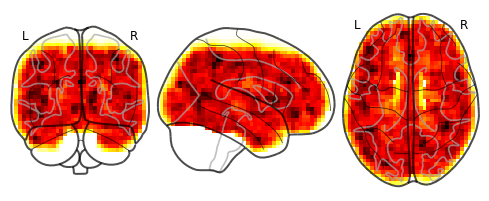

In [222]:
nii_bo_best.plot_glass_brain()

In [223]:
nii_bo_best.get_locs()

x     y     z
0     -68.0 -49.0   0.0
1     -68.0 -49.0   4.0
2     -68.0 -45.0  -8.0
3     -68.0 -45.0  -4.0
4     -68.0 -45.0   0.0
...     ...   ...   ...
16452  68.0  -9.0  28.0
16453  68.0  -5.0  12.0
16454  68.0  -5.0  16.0
16455  68.0  -5.0  20.0
16456  68.0  -5.0  24.0

[16457 rows x 3 columns]

In [226]:
yeo_all_locs = yeo_bo.get_locs().values

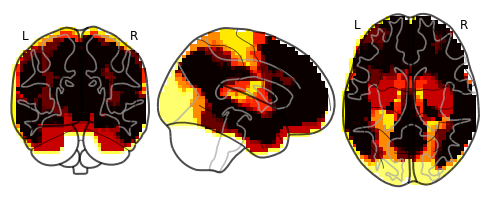

In [218]:
# copied = yeo_nii.get_data().copy()
# yeo_mask = se.Nifti(copied, template.get_affine())
# yeo_mask.plot_glass_brain()
# yeo_mask_bo = se.Brain(yeo_mask)
# yeo_all_locs = yeo_mask_bo.get_locs().values

In [224]:
yeo_all_locs.shape

(21861, 3)

In [220]:
yeo_all_locs

array([[ 69., -49.,  -3.],
       [ 69., -49.,   1.],
       [ 69., -49.,   5.],
       ...,
       [-71.,  -5.,  17.],
       [-71.,  -5.,  21.],
       [-71.,  -5.,  25.]])

In [208]:
yeo_mask = se.Nifti(copied, template.get_affine())

In [209]:
yeo_mask.get_locs()

x     y     z
0      69.0 -49.0  -3.0
1      69.0 -49.0   1.0
2      69.0 -49.0   5.0
3      69.0 -45.0 -11.0
4      69.0 -45.0  -7.0
...     ...   ...   ...
21856 -71.0  -5.0   9.0
21857 -71.0  -5.0  13.0
21858 -71.0  -5.0  17.0
21859 -71.0  -5.0  21.0
21860 -71.0  -5.0  25.0

[21861 rows x 3 columns]

In [180]:
yeo_mask = se.Nifti(copied, template.get_affine())

In [181]:
yeo_mask.get_locs()

x     y     z
0      69.0 -49.0  -3.0
1      69.0 -49.0   1.0
2      69.0 -49.0   5.0
3      69.0 -45.0 -11.0
4      69.0 -45.0  -7.0
...     ...   ...   ...
21856 -71.0  -5.0   9.0
21857 -71.0  -5.0  13.0
21858 -71.0  -5.0  17.0
21859 -71.0  -5.0  21.0
21860 -71.0  -5.0  25.0

[21861 rows x 3 columns]

In [61]:
sub_nii.plot_glass_brain()

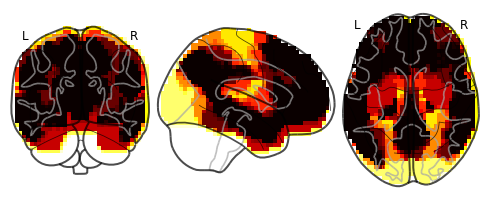

In [148]:
# copied = yeo_nii.get_data().copy()
# yeo_mask = se.Nifti(copied, yeo_nii.get_affine())
# yeo_mask.plot_glass_brain()
# yeo_mask_bo = se.Brain(yeo_mask)
# yeo_all_locs = yeo_mask_bo.get_locs().values
# #yeo_all_locs = yeo_bo.get_locs().values

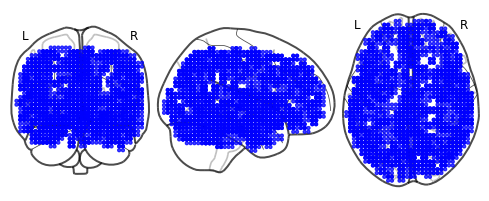

In [55]:
bo_niis.plot_locs()

In [89]:
nii_bo_center = se.helpers._brain_to_nifti(centers_bo, template)

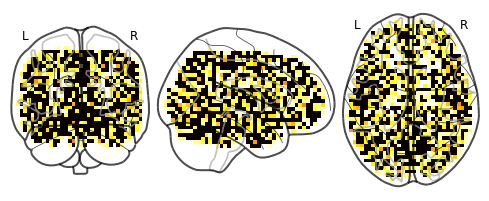

In [91]:
nii_bo_center.plot_glass_brain()
bo_niis =se.Brain(nii_bo_center)
bo_nii_locs = bo_niis.get_locs().values

In [154]:
nii_bo_center.get_locs()

x     y     z
0     65.0 -49.0   9.0
1     65.0 -49.0  13.0
2     65.0 -45.0   9.0
3     65.0 -45.0  13.0
4     65.0 -41.0  -3.0
...    ...   ...   ...
5505 -63.0 -13.0 -11.0
5506 -67.0 -33.0   1.0
5507 -67.0 -33.0   5.0
5508 -67.0 -29.0   1.0
5509 -67.0 -29.0   5.0

[5510 rows x 3 columns]

In [227]:
centers_bo = se.Brain(data=np.ones((1, centers.shape[0])), locs=centers)
nii_bo_center = se.helpers._brain_to_nifti(centers_bo, template)
bo_niis =se.Brain(nii_bo_center)
bo_nii_locs = bo_niis.get_locs().values

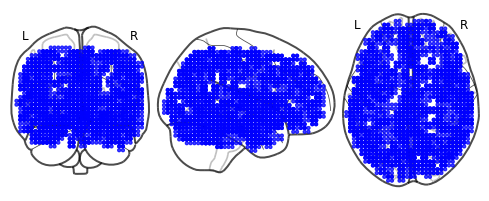

In [228]:
bo_niis.plot_locs()

In [229]:
mask_centers = bo_niis.data == 1
masked_centers_locs = bo_niis.get_locs().values[mask_centers.values.ravel()]
bo_centers_n = se.Brain(data=np.atleast_2d(np.ones(masked_centers_locs.shape[0])), locs=masked_centers_locs)
locs = bo_centers_n.get_locs().values

In [246]:
nii_bo_best = se.helpers._brain_to_nifti(b_o, template)

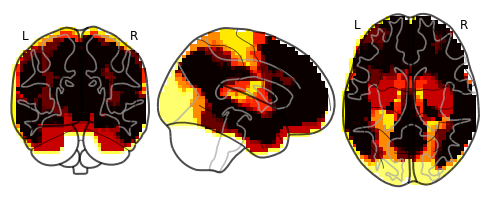

In [247]:
copied = yeo_nii.get_data().copy()
yeo_mask = se.Nifti(copied, nii_bo_best.get_affine())
yeo_mask.plot_glass_brain()
yeo_mask_bo = se.Brain(yeo_mask)
yeo_all_locs = yeo_mask_bo.get_locs().values

In [248]:
centers_bo = se.Brain(data=np.ones((1, centers.shape[0])), locs=centers)
nii_bo_center = se.helpers._brain_to_nifti(centers_bo, template)
bo_niis =se.Brain(nii_bo_center)
bo_nii_locs = bo_niis.get_locs().values

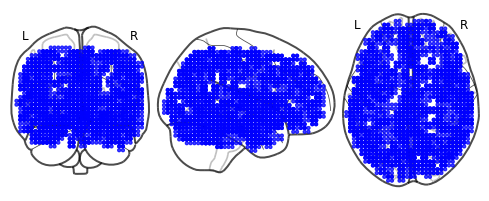

In [249]:
bo_niis.plot_locs()

In [251]:
bo_niis.data

0         1         2         3         4     5         6         7     \
0  0.17502  0.001768  0.020222  0.000204  0.127431   1.0  0.302338  0.038238   

       8         9     ...      5500  5501      5502      5503      5504  \
0  0.232367  0.039122  ...  0.061516   1.0  0.024761  0.153605  0.038873   

       5505      5506      5507      5508      5509  
0  0.239359  0.152604  0.041262  0.020919  0.005656  

[1 rows x 5510 columns]

In [240]:
yeo_bo.data

0      1      2      3      4      5      6      7      8      9      ...  \
0    7.0    7.0    7.0    7.0    7.0    7.0    7.0    2.0    4.0    7.0  ...   

   16447  16448  16449  16450  16451  16452  16453  16454  16455  16456  
0    2.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0    2.0  

[1 rows x 16457 columns]

In [242]:
centers

array([[ 25.9755079 ,  -1.10376764,  -6.14150104],
       [-52.00469442, -50.73057657,   0.59513778],
       [ 45.14574706, -68.37180248,  -6.34298181],
       ...,
       [ 52.11259092,   5.1071896 ,  40.54354753],
       [-55.68821365, -22.80868171,  32.9396829 ],
       [-48.51066977,   5.45846071,  18.84640472]])

In [315]:
centers_bo = se.Brain(data=np.ones((1, centers.shape[0])), locs=centers)

In [317]:
centers_bo.locs

x          y          z
0    25.975508  -1.103768  -6.141501
1   -52.004694 -50.730577   0.595138
2    45.145747 -68.371802  -6.342982
3   -14.530075   0.706787  15.303296
4     5.845961  17.612779  28.673850
..         ...        ...        ...
695 -51.621801 -27.319771  11.194391
696  62.806294 -40.016794  13.449101
697  52.112591   5.107190  40.543548
698 -55.688214 -22.808682  32.939683
699 -48.510670   5.458461  18.846405

[700 rows x 3 columns]

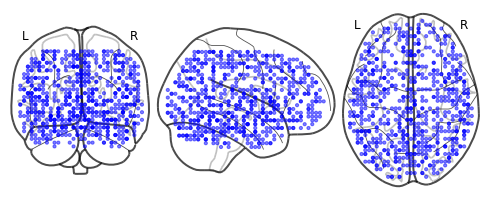

In [267]:
bo_centers_n.plot_locs()

In [275]:
yeo_bo.locs

x     y     z
0     -68.0 -49.0   0.0
1     -68.0 -49.0   4.0
2     -68.0 -45.0  -8.0
3     -68.0 -45.0  -4.0
4     -68.0 -45.0   0.0
...     ...   ...   ...
16452  68.0  -9.0  28.0
16453  68.0  -5.0  12.0
16454  68.0  -5.0  16.0
16455  68.0  -5.0  20.0
16456  68.0  -5.0  24.0

[16457 rows x 3 columns]

In [277]:
b_o.locs

x     y     z
0     -68.0 -49.0   0.0
1     -68.0 -49.0   4.0
2     -68.0 -45.0  -8.0
3     -68.0 -45.0  -4.0
4     -68.0 -45.0   0.0
...     ...   ...   ...
16452  68.0  -9.0  28.0
16453  68.0  -5.0  12.0
16454  68.0  -5.0  16.0
16455  68.0  -5.0  20.0
16456  68.0  -5.0  24.0

[16457 rows x 3 columns]

In [331]:
centers_bo.locs.values

array([[ 25.9755079 ,  -1.10376764,  -6.14150104],
       [-52.00469442, -50.73057657,   0.59513778],
       [ 45.14574706, -68.37180248,  -6.34298181],
       ...,
       [ 52.11259092,   5.1071896 ,  40.54354753],
       [-55.68821365, -22.80868171,  32.9396829 ],
       [-48.51066977,   5.45846071,  18.84640472]])

In [330]:
yeo_bo.locs.values

array([[-68., -49.,   0.],
       [-68., -49.,   4.],
       [-68., -45.,  -8.],
       ...,
       [ 68.,  -5.,  16.],
       [ 68.,  -5.,  20.],
       [ 68.,  -5.,  24.]])

In [338]:
network_bo = _near_neighbor(centers_bo, yeo_bo)

In [393]:
centers_bo = se.Brain(data=np.ones((1, centers.shape[0])), locs=centers)

In [394]:
centers_bo = copy.deepcopy(centers_bo) #FIXME: copying is expensive...
centers_bo.orig_locs = centers_bo.locs

In [395]:
centers_bo

In [396]:
d = cdist(centers_bo.locs, yeo_bo.locs, metric='Euclidean')

In [397]:
d

array([[105.65587156, 105.96365039, 103.73875515, ...,  47.66009474,
         49.64490547,  51.86278673],
       [ 16.0996548 ,  16.44499263,  19.0411581 , ..., 129.34342696,
        129.88056435, 130.53811663],
       [114.9672137 , 115.25712161, 115.54629781, ...,  70.97542577,
         72.33432738,  73.88503754],
       ...,
       [137.83468979, 136.71156984, 138.90371108, ...,  30.93462097,
         27.8675868 ,  25.06499579],
       [ 43.84732542,  40.92762494,  48.16733672, ..., 126.10660648,
        125.63183806, 125.28304463],
       [ 60.83374809,  59.71577404,  60.38724779, ..., 117.01374958,
        116.98481249, 117.09259206]])

In [401]:
min_ind[1]

4346

In [404]:
yeo_bo.data.iloc[:, min_ind[1]]

0    4.0
Name: 4346, dtype: float64

In [405]:
for i in range(len(centers_bo.locs)):
    min_ind = list(zip(*np.where(d == d.min())))[0]
    centers_bo.locs.iloc[min_ind[0], :] = yeo_bo.locs.iloc[min_ind[1], :]
    centers_bo.data.iloc[:, min_ind[0]] = yeo_bo.data.iloc[:, min_ind[1]]
    d[min_ind[0]] = np.inf
    d[:, min_ind[1]] = np.inf

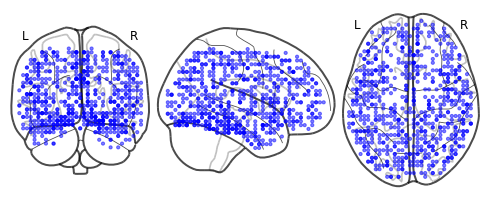

In [406]:
centers_bo.plot_locs()

In [407]:
centers_bo.data

0    1    2    3    4    5    6    7    8    9    ...  690  691  692  693  \
0  4.0  7.0  1.0  6.0  4.0  6.0  1.0  4.0  5.0  5.0  ...  1.0  1.0  1.0  4.0   

   694  695  696  697  698  699  
0  5.0  2.0  2.0  3.0  4.0  6.0  

[1 rows x 700 columns]

In [408]:
all_inds = se.helpers.get_rows(b_o.locs.values, centers_bo.locs.values)



In [409]:
all_inds

[12645,
 1238,
 13532,
 7627,
 8703,
 9184,
 6721,
 3838,
 4694,
 8287,
 16109,
 2496,
 13983,
 11110,
 4600,
 7866,
 13291,
 15858,
 9657,
 5848,
 12451,
 13189,
 3281,
 8993,
 12324,
 8545,
 2356,
 1891,
 15049,
 4923,
 8714,
 12004,
 4768,
 7631,
 14281,
 9806,
 5307,
 3965,
 13444,
 2216,
 8424,
 11292,
 6393,
 5275,
 13506,
 2273,
 15501,
 10351,
 4190,
 3527,
 6046,
 1345,
 14523,
 12098,
 420,
 8192,
 9710,
 8492,
 16103,
 3165,
 10139,
 15492,
 4962,
 1086,
 7415,
 10870,
 10758,
 14496,
 15257,
 2702,
 15388,
 8755,
 9035,
 3713,
 10396,
 10566,
 5851,
 1979,
 14226,
 6872,
 975,
 14012,
 7119,
 9443,
 12647,
 9560,
 7546,
 5589,
 13060,
 12044,
 3470,
 6183,
 5990,
 12582,
 13161,
 11531,
 2743,
 5170,
 8898,
 2393,
 754,
 2018,
 1234,
 14159,
 5903,
 1323,
 6001,
 1204,
 11238,
 5241,
 15445,
 6412,
 12194,
 7233,
 6338,
 11362,
 8683,
 537,
 7578,
 840,
 6201,
 13387,
 14459,
 10303,
 5016,
 1045,
 1492,
 6810,
 8351,
 2503,
 4928,
 10755,
 13811,
 700,
 6777,
 8092,
 11222

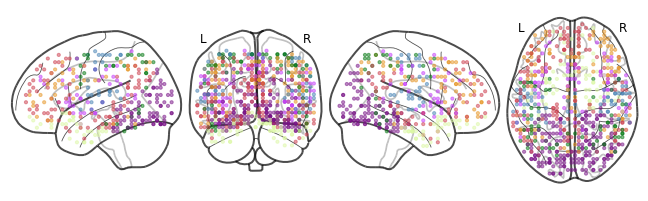

In [410]:
#yeo_all_locs = yeo_bo.get_locs().as_matrix()
ni_plt.plot_connectome(np.eye(b_o.locs.values[all_inds].shape[0]), b_o.locs.values[all_inds], output_file=None,
                               node_kwargs={'alpha': 0.5, 'edgecolors': None},
                               node_size=10, node_color=color_all[all_inds], display_mode='lyrz')



In [411]:
networks_bo = centers_bo

In [413]:
network_bo_outfile = os.path.join('/Users/lucyowen/repos/pca_paper-1/data/niis/networks', 'networks.npz')

np.savez(network_bo_outfile, locs=networks_bo.locs.values, data=networks_bo.data.values)


In [217]:
ddir

'../../data/'

(183, 3)
(58, 3)
(64, 3)
(82, 3)
(76, 3)
(94, 3)
(143, 3)


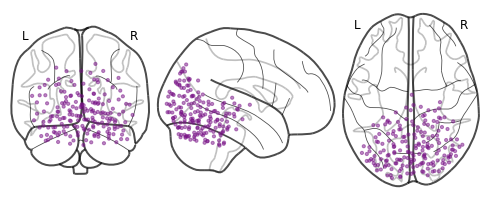

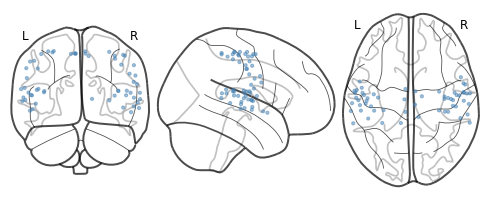

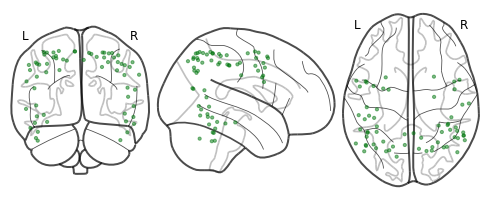

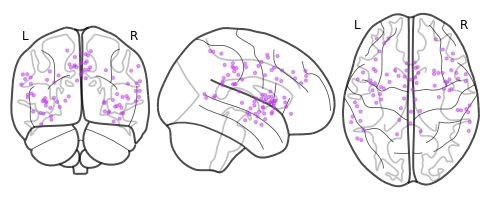

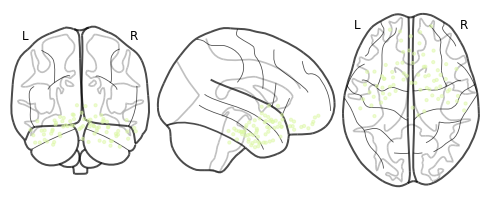

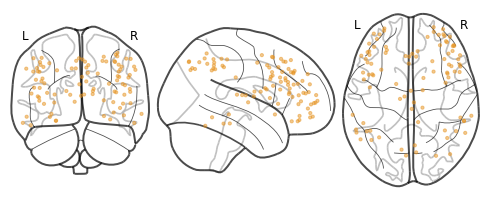

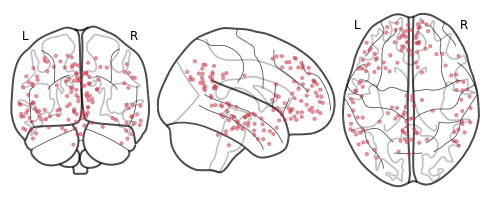

In [386]:
for n in np.arange(1, n_nets+1):
    mask_n = network_bo.get_data()==n
    masked_locs = network_bo.get_locs().values[mask_n.values.ravel()]
    bo_n = se.Brain(data=np.atleast_2d(np.ones(masked_locs.shape[0])), locs=masked_locs)
    locs = bo_n.get_locs()
    print(locs.shape)
    colors = color_stacked[n-1]
    repeats_colors = np.tile(colors, (locs.shape[0], 1))
    ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': 0.5, 'edgecolors': None},
                                   node_size=10, node_color=repeats_colors)


In [98]:
factors=700
debug=False
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name ='../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']
pieman_data = loadmat(pieman_name)

In [99]:

if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [100]:
data = np.array(data)
conds = np.array(conds)

In [101]:
pwd

'/Users/lucyowen/repos/pca_paper/code/notebooks'

In [113]:
network_cmaps = ["Purples", "Greens", "Blues", "RdPu", "YlGnBu", "YlOrRd", "Reds"]

Visual


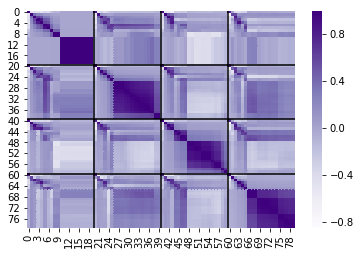

Somatomotor


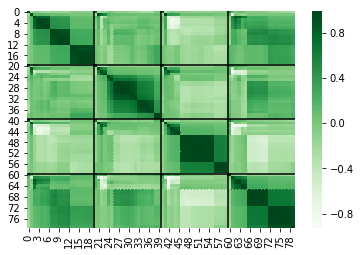

Dorsal Attention


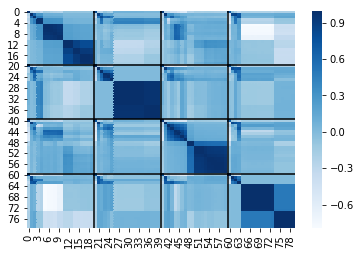

Ventral Attention


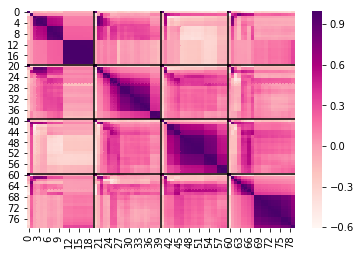

Limbic 


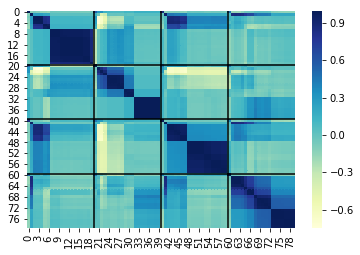

Frontoparietal


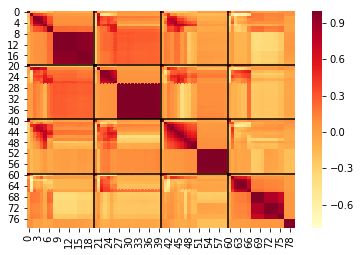

Default


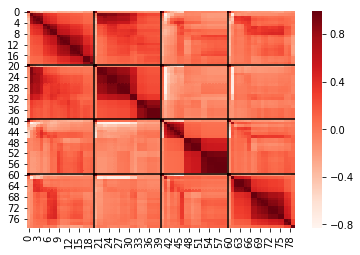

<Figure size 432x288 with 0 Axes>

In [114]:
conditions = ['intact', 'paragraph', 'word', 'rest']
#conditions = ['intact']

for n in np.arange(1, n_nets+1):
    mask_n = network_bo.get_data()==n
    print(yeo_colors[yeo_colors.inds==n]['labels'].values[0])
    n_comps = 20
    stacked_conditions = np.array([])
    for c in conditions:
        x = list(data[conds == c])
        split = np.cumsum([len(xi) for xi in x])[:-1]

        pca = IncrementalPCA(n_components=20)
        x_r = np.vsplit(pca.fit_transform(np.vstack(x)[:, mask_n.as_matrix().flatten()]), split)

        stacked_dims = np.array([])
        try_divide = np.divide(pca.components_.T, pca.components_.mean(axis=1)).T

        for i in np.arange(n_comps):

            try_divide[:i+1].sum(axis=0)

            if stacked_dims.shape[0]==0:
                stacked_dims = try_divide[:i+1].sum(axis=0)
            else:
                stacked_dims = np.vstack((stacked_dims, try_divide[:i+1].sum(axis=0)))  

        if stacked_conditions.shape[0]==0:
            stacked_conditions = stacked_dims
        else:
            stacked_conditions = np.vstack((stacked_conditions, stacked_dims))

    heated = 1 - scipy.spatial.distance.cdist(stacked_conditions, stacked_conditions, 'correlation')

    ax = sns.heatmap(heated, cmap=network_cmaps[n-1])
    ax.hlines([n_comps, n_comps*2, n_comps*3], *ax.get_xlim())
    ax.vlines([n_comps, n_comps*2, n_comps*3], *ax.get_xlim())
    plt.show()
    plt.clf()

In [225]:
for n in np.arange(1, n_nets+1):
    mask_n = yeo_mask_bo.get_data()==n
    masked_locs = yeo_all_locs[mask_n.as_matrix().ravel()]
    bo_n = se.Brain(data=np.atleast_2d(np.ones(masked_locs.shape[0])), locs=masked_locs)
    locs = bo_n.get_locs()
    #colors = magma_colors[n-1]
    colors = color_stacked[n-1]
    ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': 0.5, 'edgecolors': None},
                                   node_size=10, node_color=colors)


NameError: name 'yeo_mask_bo' is not defined

In [ ]:

b_file = os.path.join(pca_nii_bo_dir,f'{c}_{pc}_pca.bo')
pc_bo = se.load(b_file)
nii_bo_best = se.helpers._brain_to_nifti(pc_bo, sub_nii)
#pc_nii = se.load(b_file, return_type='nii', vox_size=4)
nii_bo_best.plot_glass_brain()
mask = nii_bo_best.get_data() > 0
rounded_vals = np.round_(yeo_nii.get_data()[mask])
counts = np.array(np.unique(rounded_vals[~np.isnan(rounded_vals)], return_counts=True))
#counts = np.array(np.unique(yeo_nii.get_data()[mask], return_counts=True))

copied = yeo_nii.get_data().copy()
copied[mask + 0 == 0] = 0.
#mask = mask *1

#copied[mask] = 0
temp_mask = se.Nifti(copied, nii_bo_best.get_affine())
temp_mask.plot_glass_brain()
temp_bo = se.Brain(temp_mask)
temp_bo.plot_locs()
outfile = os.path.join(networks_nii_bo_dir, f'{c}_{pc}_network.bo')
temp_bo.save(outfile)

data_vals = temp_bo.get_data().values.tolist()
color_all = np.array([])
for i, v in enumerate(data_vals[0]):
    ind_color = int(v-1)
    if color_all.shape[0]==0:
        color_all = color_stacked[ind_color]
    else:
        color_all = np.vstack((color_all, color_stacked[ind_color]))


locs = temp_bo.get_locs().as_matrix()
ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                               node_kwargs={'alpha': 0.5, 'edgecolors': None},
                               node_size=10, node_color=color_all)


ni_plt.show()

nets = counts[0][counts[0]>0]
counts = counts[1][counts[0]>0]

pie_colors = np.array([])
color_labels = []

for net in nets:
    n = int(round(net))
    if pie_colors.shape[0]==0:
        pie_colors = color_stacked[int(n-1)]
        color_labels.append(yeo_colors[yeo_colors.inds==n]['labels'].values[0])
    else:
        pie_colors = np.vstack((pie_colors, color_stacked[int(n-1)]))
        color_labels.append(yeo_colors[yeo_colors.inds==n]['labels'].values[0])

print(color_labels)

#scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['Normed_corr'])[0]
#scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['new_normed_corr'])[0]
scale_pie = 1
print(scale_pie)
size = 1

fig = plt.figure(figsize=[10*scale_pie, 10*scale_pie])
patches, texts = plt.pie(counts/counts.sum(), colors=sns.color_palette(pie_colors), radius=scale_pie, shadow=False, startangle=90, wedgeprops=dict(width=scale_pie, edgecolor='w'))
#plt.legend(patches, color_labels, loc='upper left', bbox_to_anchor=(0.95, .45, 0.5, 0.5), fontsize = 'large')
#plt.axis('equal')
#plt.tight_layout()
pie_outfile = os.path.join(fig_dir, c + '_'+ str(pc) + '_network_pie.pdf')
#plt.savefig(pie_outfile)
plt.show()   

In [223]:
nets = counts[0][counts[0]>0]
counts = counts[1][counts[0]>0]

NameError: name 'counts' is not defined

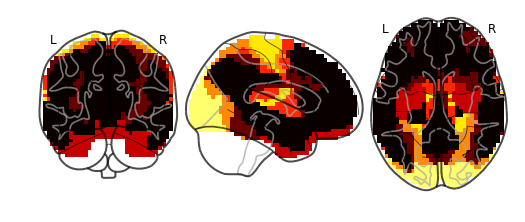

In [224]:
yeo_nii.plot_glass_brain()

In [31]:
mean_best_loc = pd.read_csv(os.path.join(freq_fig_dir, 'mean_best_loc.csv'))

In [32]:
raw_mean = mean_best_loc[mean_best_loc['Freq']=='raw']['Corr'][0]

In [33]:
mean_best_loc['Normed_corr'] = mean_best_loc['Corr']/raw_mean

In [34]:
mean_best_loc

Unnamed: 0      Corr       Freq  Normed_corr
0           0  0.522776        raw     1.000000
1           1  0.542936      delta     1.038563
2           2  0.576721      theta     1.103190
3           3  0.557029      alpha     1.065522
4           4  0.529582       beta     1.013019
5           5  0.459669     lgamma     0.879285
6           6  0.438820     hgamma     0.839404
7           7  0.641968  broadband     1.227999

In [35]:
mean_best_loc['Corr'].min()

0.4388200511486988

In [36]:
mean_best_loc['min_corr'] = mean_best_loc['Corr'] - mean_best_loc['Corr'].min()


In [37]:
mean_best_loc['new_normed_corr'] = mean_best_loc['min_corr']/mean_best_loc['min_corr'].max() + .5

raw


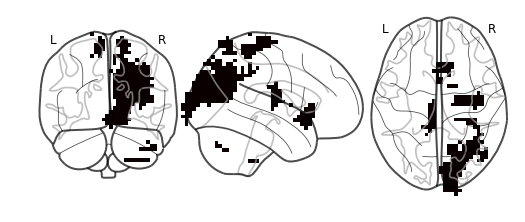

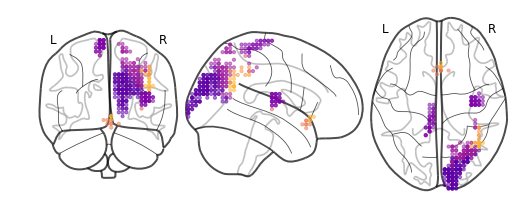

['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Limbic ', 'Frontoparietal', 'Default']
0.913273887657788


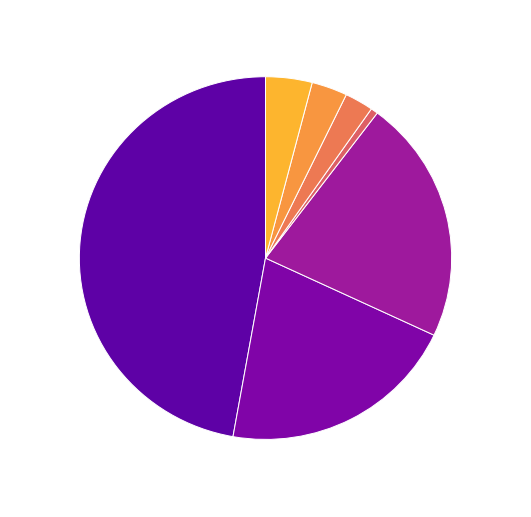

delta


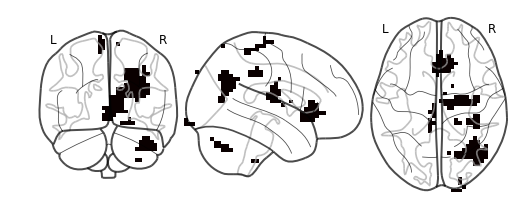

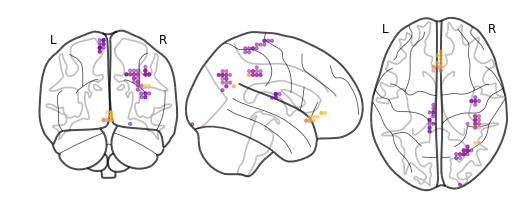

['Visual', 'Somatomotor', 'Dorsal Attention', 'Limbic ', 'Frontoparietal', 'Default']
1.0125113163288928


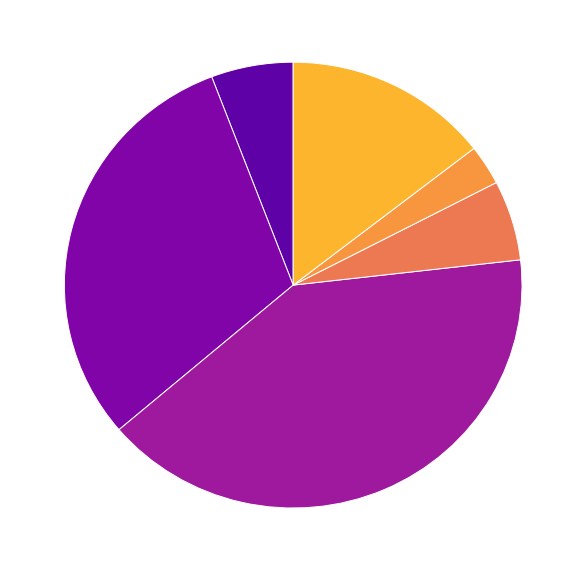

theta


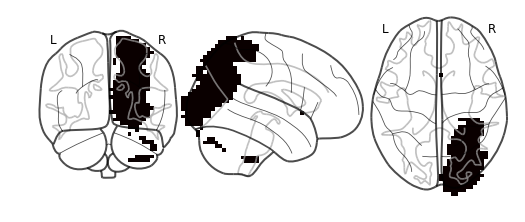

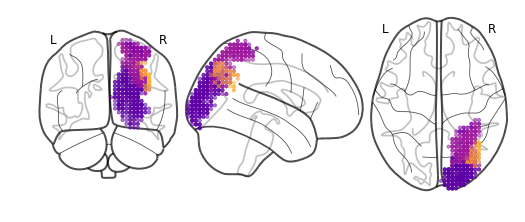

['Visual', 'Somatomotor', 'Dorsal Attention', 'Frontoparietal', 'Default']
1.1788213728711021


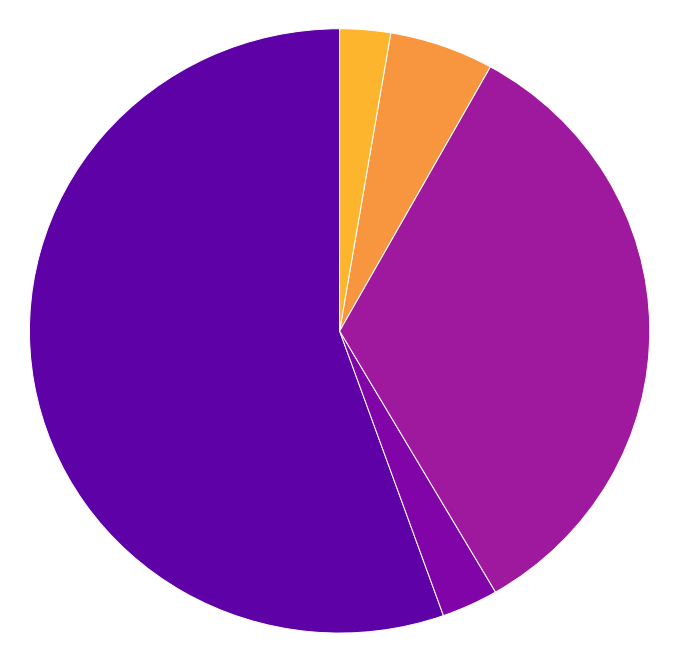

alpha


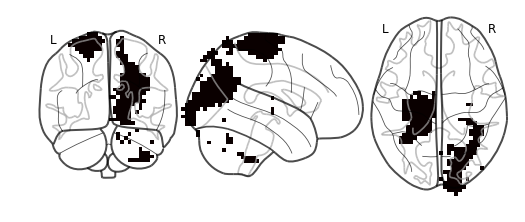

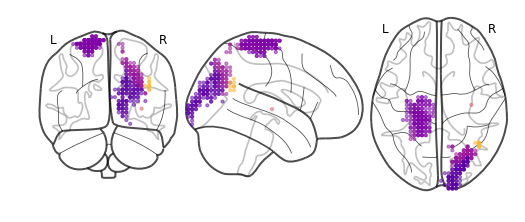

['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Default']
1.0818858313834494


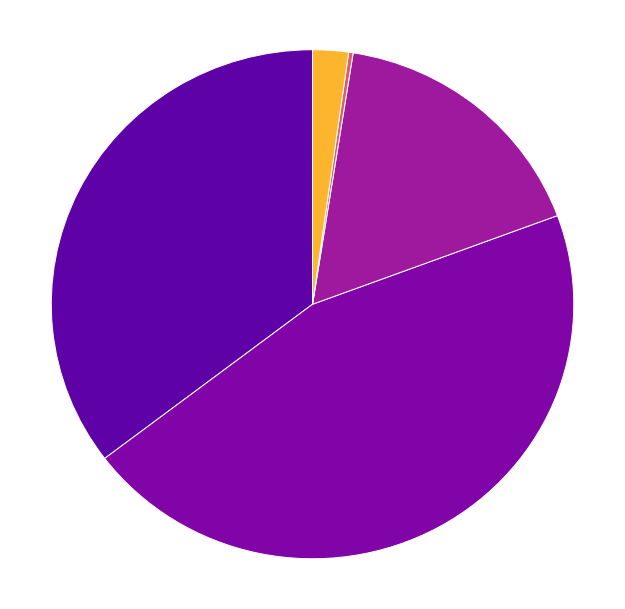

beta


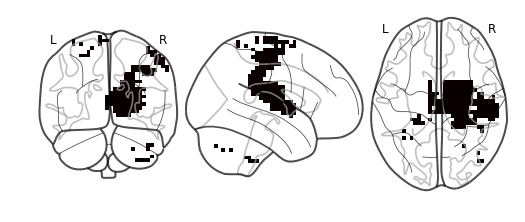

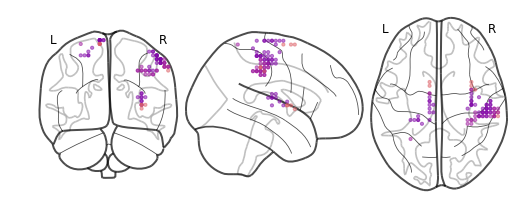

['Somatomotor', 'Dorsal Attention', 'Ventral Attention']
0.9467754184439305


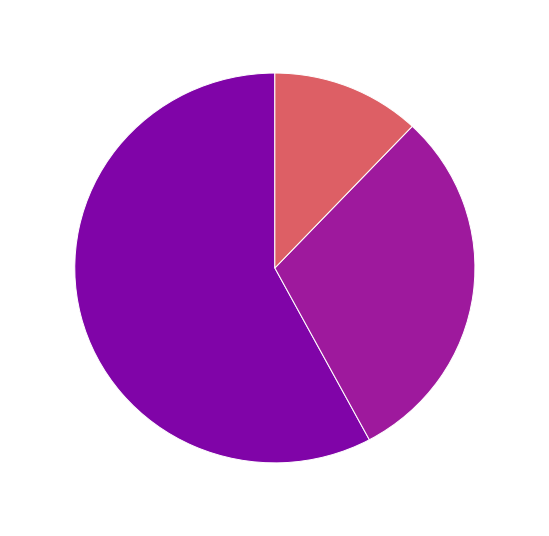

lgamma


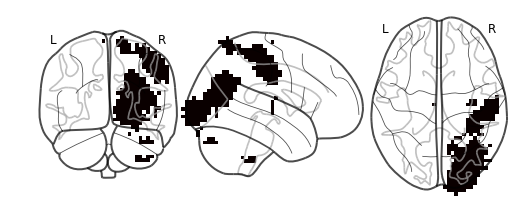

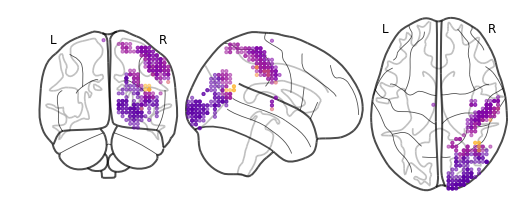

['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Frontoparietal', 'Default']
0.6026297191757002


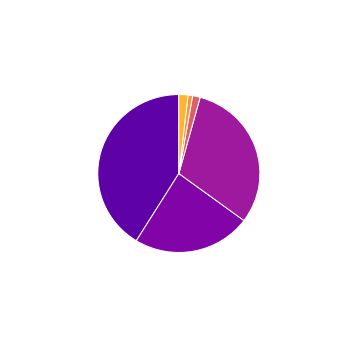

hgamma


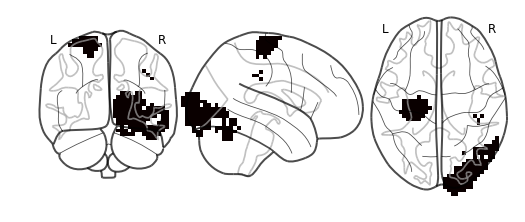

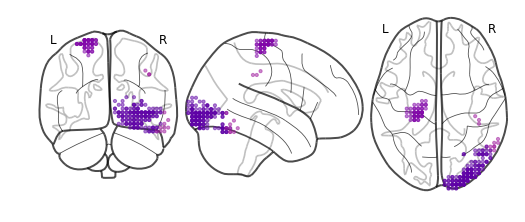

['Visual', 'Somatomotor', 'Dorsal Attention']
0.5


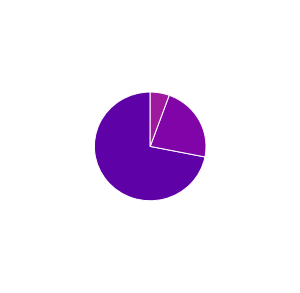

broadband


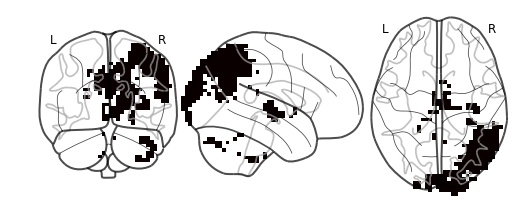

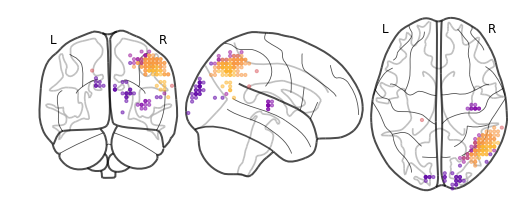

['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Frontoparietal', 'Default']
1.5


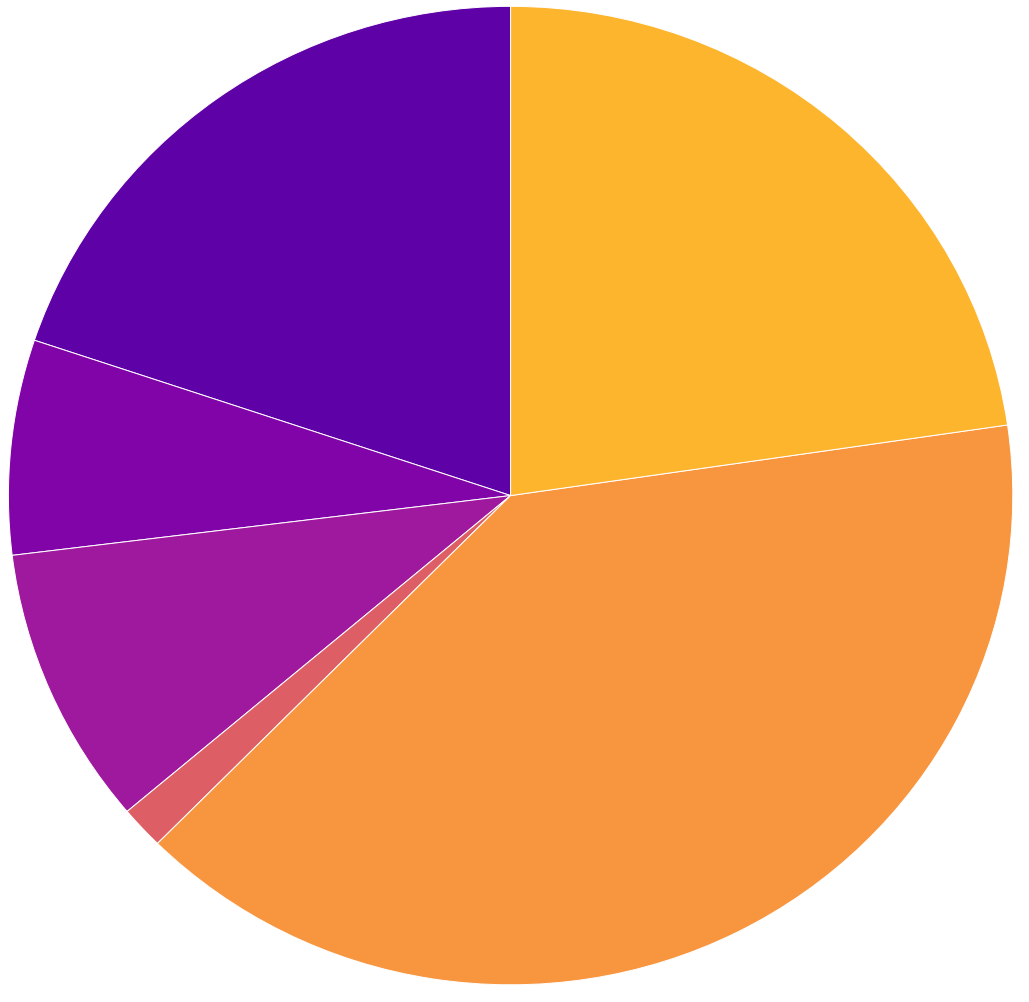

In [38]:
freqs = ['raw', 'delta', 'theta', 'alpha', 'beta', 'lgamma', 'hgamma', 'broadband']
for f in freqs:
    
    print(f)
    freq_file = os.path.join(freq_nii_bo_dir, f + '_best.bo')
    freq_nii = se.load(freq_file, return_type='nii')
    freq_nii.plot_glass_brain()
    mask = freq_nii.get_data() > 0
    counts = np.array(np.unique(yeo_nii.get_data()[mask], return_counts=True))
    
    copied = yeo_nii.get_data().copy()
    copied[mask + 0 == 0] = 0.
    temp_mask = se.Nifti(copied, yeo_nii.get_affine())
    temp_bo = se.Brain(temp_mask)
    
    outfile = os.path.join(networks_nii_bo_dir, f + '_network')
    temp_bo.save(outfile)
    
    data_vals = temp_bo.get_data().values.tolist()
    color_all = np.array([])
    for i, v in enumerate(data_vals[0]):
        ind_color = int(v-1)
        if color_all.shape[0]==0:
            color_all = magma_colors[ind_color]
        else:
            color_all = np.vstack((color_all, magma_colors[ind_color]))
        
            
    locs = temp_bo.get_locs().as_matrix()
    ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': 0.5, 'edgecolors': None},
                                   node_size=10, node_color=color_all)


    ni_plt.show()
    
    nets = counts[0][counts[0]>0]
    counts = counts[1][counts[0]>0]
    
    pie_colors = np.array([])
    color_labels = []
            
    for c in nets:
    
        if pie_colors.shape[0]==0:
            pie_colors = magma_colors[int(c-1)]
            color_labels.append(yeo_colors[yeo_colors.inds==c]['labels'].values[0])
        else:
            pie_colors = np.vstack((pie_colors, magma_colors[int(c-1)]))
            color_labels.append(yeo_colors[yeo_colors.inds==c]['labels'].values[0])
    
    print(color_labels)
    
    #scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['Normed_corr'])[0]
    scale_pie = np.array(mean_best_loc[mean_best_loc['Freq']==f]['new_normed_corr'])[0]
    
    print(scale_pie)
    size = 1
    
    fig = plt.figure(figsize=[10*scale_pie, 10*scale_pie])
    patches, texts = plt.pie(counts/counts.sum(), colors=sns.color_palette(pie_colors), radius=scale_pie, shadow=False, startangle=90, wedgeprops=dict(width=scale_pie, edgecolor='w'))
    #plt.legend(patches, color_labels, loc='upper left', bbox_to_anchor=(0.95, .45, 0.5, 0.5), fontsize = 'large')
    #plt.axis('equal')
    #plt.tight_layout()
    pie_outfile = os.path.join(fig_dir, f + '_network_pie.pdf')
    plt.savefig(pie_outfile)
    plt.show()   

In [39]:
yeo_colors['labels'].values.tolist()

['Visual',
 'Somatomotor',
 'Dorsal Attention',
 'Ventral Attention',
 'Limbic ',
 'Frontoparietal',
 'Default']

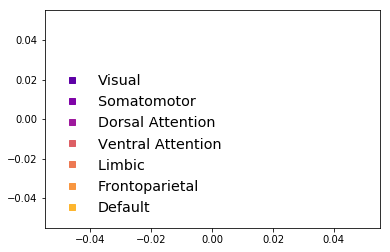

In [41]:
#colors = list(color_stacked/255)
colors = magma_colors
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(n_nets)]
labels = yeo_colors['labels'].values.tolist()
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False, fontsize = 'x-large')

def export_legend(legend, filename=os.path.join(fig_dir,'yeo_legend.pdf'), expand=[-1,-1,0,0]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

In [51]:
try_nii = se.load('/Users/lucyowen/Downloads/reading_association-test_z_FDR_0.01.nii')

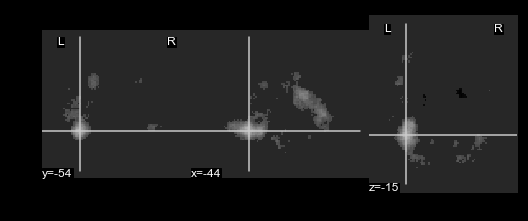

In [56]:
try_nii.plot_anat()

In [58]:
try_bo = se.Brain(try_nii)

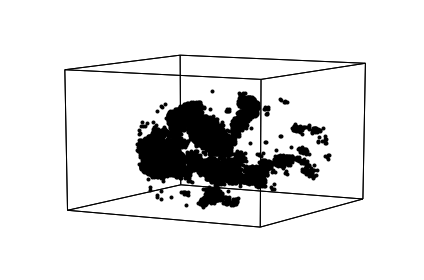

In [59]:
try_bo.plot_locs()

In [61]:
try_nii2 = se.Nifti(try_bo)

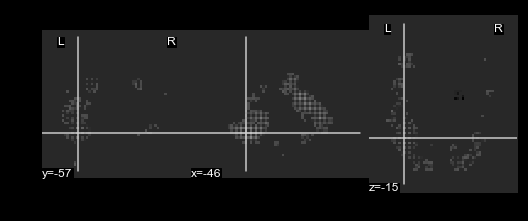

In [62]:
try_nii2.plot_anat()

In [63]:
try_nii2.save('/Users/lucyowen/Downloads/reading_supereeg_try')